In [1]:
import argparse
import random
from tqdm import tqdm
from datetime import datetime, timedelta
from collections import OrderedDict

import pandas as pd

import torch
import numpy as np
import pandas as pd

from configs import *
from inference import *
from sampling import *

from ofold.np import residue_constants

from flowmatch import flowmatcher

from model import main_network
from flowmatch.data import utils as du
from evaluation.metrics import *
from evaluation.loss import *
from data.utils import *
from data.loader import *
from data.data import *

from Bio.PDB import PDBParser, PDBIO

INFO: Using numpy backend
INFO: Enabling RDKit 2022.09.5 jupyter extensions


In [2]:
# Args

args = Args()
args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if args.discrete_flow_type == 'uniform':
    args.num_aa_type = 20
    args.masked_aa_token_idx = None


    if args.flow_msa:
        args.msa.num_msa_vocab = 64
        args.msa.masked_msa_token_idx = None

    if args.flow_ec:
        args.ec.num_ec_class = 6
        args.ec.masked_ec_token_idx = None
        

# discrete
elif args.discrete_flow_type == 'masking':
    args.num_aa_type = 21
    args.masked_aa_token_idx = 20
    args.aa_ot = False


    if args.flow_msa:
        args.msa.num_msa_vocab = 65
        args.msa.masked_msa_token_idx = 64
        args.msa_ot = False

    if args.flow_ec:
        args.ec.num_ec_class = 7
        args.ec.masked_ec_token_idx = 6

else:
    raise ValueError(f'Unknown discrete flow type {args.discrete_flow_type}')

In [20]:
# Loading Model

flow_model = flowmatcher.SE3FlowMatcher(args)
model = main_network.ProteinLigandNetwork(args)
model = model.to(args.device)

ckpt_path = 'checkpoint/enzymeflow_mini.ckpt'
if ckpt_path:
    print(f'loading pretrained weights for enzymeflow {ckpt_path}')
    checkpoint = torch.load(ckpt_path, map_location='cpu')
    model_state_dict = checkpoint["model_state_dict"]

    new_state_dict = OrderedDict()
    for k, v in model_state_dict.items():
        name = k # remove `module.`
        new_state_dict[name] = v

    model.load_state_dict(new_state_dict, strict=True)

loading pretrained weights for enzymeflow checkpoint/enzymeflow_mini.ckpt


/var/folders/gr/224jg39x7y75fgmkq_9br_9r0000gn/T/ipykernel_61785/4039883123.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_locat

In [5]:
# Read metadata/rawdata

raw_eval_csv = pd.read_csv('data/eval-data_cutoff-0.1_unique-subs-enz_100.csv')
meta_eval_csv = pd.read_csv('data/metadata_eval.csv')

In [6]:
# Print metadata/rawdata

eval_id = 0
eval_csv_row = meta_eval_csv.iloc[eval_id]
pdb_name = eval_csv_row['pdb_name']
substrate_name = eval_csv_row['substrate_name']

generated_prot = f'{pdb_name}_{substrate_name}'

print(eval_csv_row)

processed_ligand_path          /Users/willhua/Desktop/EnzymeFlow/data/process...
processed_protein_path         /Users/willhua/Desktop/EnzymeFlow/data/process...
processed_product_path         /Users/willhua/Desktop/EnzymeFlow/data/process...
processed_reaction_msa_path    /Users/willhua/Desktop/EnzymeFlow/data/process...
processed_enzyme_msa_path      /Users/willhua/Desktop/EnzymeFlow/data/process...
pdb_name                                                                  P07964
substrate_name                                                             12616
product_name                                                                5647
raw_protein_path                           data/raw_eval_data/protein/P07964.pdb
raw_ligand_path                           data/raw_eval_data/molecule/12616.mol2
num_ligand_atom                                                               28
num_protein_amino_acid                                                        32
num_protein_atom            

In [7]:
import py3Dmol

gt_prot_path = f'data/raw_eval_data/protein/{pdb_name}.pdb'

with open(gt_prot_path) as ifile:
    gt_system = "".join([f for f in ifile])


view = py3Dmol.view(width=300, height=300)
view.addModelsAsFrames(gt_system)
view.setStyle({'model': 0}, {"cartoon": {'color': 'spectrum'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

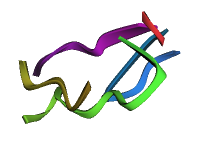

In [8]:
# in case pymol didnt show in html
from IPython.display import Image
Image(filename='image/image1.png') 

In [9]:
# Run EnzymeFlow Sampling

args.flow_msa = True
args.eval.aa_temp = 10.
args.eval.msa_temp = 10.
args.eval.ec_temp = 10.
args.eval.aa_noise = 20.
args.eval.msa_noise = 40.
args.eval.ec_noise = 0.

n_sample = 10
parent_dir = os.path.join('generated/enzymeflow_demo', generated_prot)
os.makedirs(parent_dir, exist_ok=True)

pred_ec = []
for seed in tqdm(range(0, n_sample)):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
    feats_0 = parse_sampling_feats(args, meta_eval_csv, gen_model=flow_model, eval_row_id=eval_id)
    feats_0 = {key: value.unsqueeze(0) for key, value in feats_0.items()}
    
    feats_1 = sampling_inference(
                args,
                init_feats = feats_0,
                gen_model = flow_model,
                main_network = model,
                min_t = 0.0,
                max_t = 1.0,
                num_t = 50,
                self_condition = False,
                center = True,
                aa_do_purity = True,
                msa_do_purity = True,
                ec_do_purity = True,
                rot_sample_schedule = 'exp',
                trans_sample_schedule = 'linear',
            )

    pred_ec.append(feats_1["ec_traj"][0].item()+1)

    
    write_pdb_traj(
        args,
        feats_0=feats_0, 
        feats_1=feats_1, 
        parent_dir=parent_dir, 
        pdb_name=pdb_name, 
        substrate_name=substrate_name, 
        sample_id=seed,
    )

100%|█████████████████████████████████████████████| 10/10 [00:42<00:00,  4.25s/it]


In [10]:
gt_prot_path = f'data/raw_eval_data/protein/{pdb_name}.pdb'
gt_structure = parse_prot_structure(gt_prot_path, 'ground')
seq_idx = find_sequence_index(gt_structure)

gt_ec = []
for seed in tqdm(range(0, n_sample)):    
    pred_prot_path = os.path.join(parent_dir, generated_prot, f'sample_{seed}.pdb')
    pred_structure = parse_prot_structure(pred_prot_path, 'example')
    
    change_sequence_index(pred_structure, seq_idx)
    
    io = PDBIO()
    io.set_structure(pred_structure)
    
    mod_prot_path = os.path.join(parent_dir, generated_prot, f"sample_{seed}_modseq.pdb")
    io.save(mod_prot_path)

    gt_pdb = process_pdb(gt_prot_path)
    pred_pdb = process_pdb(pred_prot_path)
    
    gt_aatype = du.move_to_np(gt_pdb['aatype'])
    pred_aatype = du.move_to_np(pred_pdb['aatype'])
    res_mask = du.move_to_np(torch.ones(len(gt_pdb['aatype'])))
    
    gt_protein_pos = du.move_to_np(gt_pdb['atom37_pos'])
    pred_protein_pos = du.move_to_np(pred_pdb['atom37_pos'])
    
    amino_acid_recovery = compute_amino_acid_recovery_rate(pred_aatype, gt_aatype, res_mask)
    
    sample_metrics, _ = protein_metrics(
                            pdb_path=pred_prot_path,
                            atom37_pos=pred_protein_pos,
                            pred_aatype=pred_aatype,
                            gt_atom37_pos=gt_protein_pos,
                            gt_aatype=gt_aatype,
                            flow_mask=res_mask,
                        )
    
    amino_acid_recovery = compute_amino_acid_recovery_rate(pred_aatype, gt_aatype, res_mask)
    sample_metrics["aar"] = amino_acid_recovery

    gt_ec.append(int(eval_csv_row['ec_class']))
    ec_acc = int(eval_csv_row['ec_class']) == pred_ec[seed]
    sample_metrics["ec_acc"] = ec_acc


    # align structures
    sample_structure = parse_prot_structure(mod_prot_path, 'sample')
    
    align_prot_path = os.path.join(parent_dir, generated_prot, f"sample_{seed}_aligned.pdb")
    aligned_structure = align_structure(gt_structure, sample_structure, align_prot_path)

100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 42.43it/s]


In [11]:
import py3Dmol
gt_prot_path = f'data/raw_eval_data/protein/{pdb_name}.pdb'
pred_prot_path = os.path.join(parent_dir, generated_prot, f"sample_{seed}.pdb")
mod_prot_path = os.path.join(parent_dir, generated_prot, f"sample_{seed}_modseq.pdb")

ref_structure = parse_prot_structure(gt_prot_path, 'reference')
sample_structure = parse_prot_structure(mod_prot_path, 'sample')

align_prot_path = os.path.join(parent_dir, generated_prot, f"sample_{seed}_aligned.pdb")
aligned_structure = align_structure(ref_structure, sample_structure, align_prot_path)

In [12]:
# Visualize the generated structure

with open(gt_prot_path) as ifile:
    gt_system = "".join([f for f in ifile])

with open(os.path.join(pred_prot_path)) as ifile:
    pred_system = "".join([f for f in ifile])

view = py3Dmol.view(width=300, height=300)
view.addModelsAsFrames(gt_system)
view.setStyle({'model': 0}, {"cartoon": {'opacity': 0.6}})

view.addModelsAsFrames(pred_system)
view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

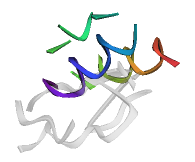

In [13]:
Image(filename='image/image2.png') 

In [14]:
# Visualize the generated structure -- after reindexing the residue index

with open(gt_prot_path) as ifile:
    gt_system = "".join([f for f in ifile])

with open(mod_prot_path) as ifile:
    pred_system = "".join([f for f in ifile])

view = py3Dmol.view(width=300, height=300)
view.addModelsAsFrames(gt_system)
view.setStyle({'model': 0}, {"cartoon": {'opacity': 0.6}})

view.addModelsAsFrames(pred_system)
view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

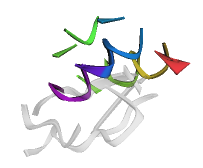

In [15]:
Image(filename='image/image3.png') 

In [16]:
# Visualize the generated structure aligned to the ground-truth structure

with open(gt_prot_path) as ifile:
    gt_system = "".join([f for f in ifile])

with open(align_prot_path) as ifile:
    pred_system = "".join([f for f in ifile])

view = py3Dmol.view(width=300, height=300)
view.addModelsAsFrames(gt_system)
view.setStyle({'model': 0}, {"cartoon": {'opacity': 0.6}})

view.addModelsAsFrames(pred_system)
view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

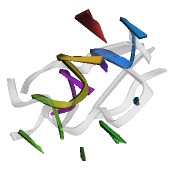

In [17]:
Image(filename='image/image4.png') 